# Load data

In [2]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.measure import regionprops
from skimage import io
import matplotlib.pyplot as plt
import argparse, os, cv2
import numpy as np

plt.style.use('bmh')
np.random.seed(42)

In [3]:
'''
loading images
'''
nevus_filepath = 'data/0/'
melanoma_filepath = 'data/1/'

nevus_files = [f for f in os.listdir(nevus_filepath) if os.path.isfile(nevus_filepath+f)]
melanoma_files = [f for f in os.listdir(melanoma_filepath) if os.path.isfile(melanoma_filepath+f)]
# sort filenames
nevus_files = sorted(nevus_files)
melanoma_files = sorted(melanoma_files)

N = 10
nevus_imgs = [plt.imread(os.path.join(nevus_filepath, nevus_files[i])) for i in range(N)]
melanoma_imgs = [plt.imread(os.path.join(melanoma_filepath, melanoma_files[i])) for i in range(N)]

# resize
nevus_imgs = [cv2.resize(img,(256,256)) for img in nevus_imgs]
melanoma_imgs = [cv2.resize(img,(256,256)) for img in melanoma_imgs]

nevus_imgs = np.array(nevus_imgs)
melanoma_imgs = np.array(melanoma_imgs)

# SLIC  

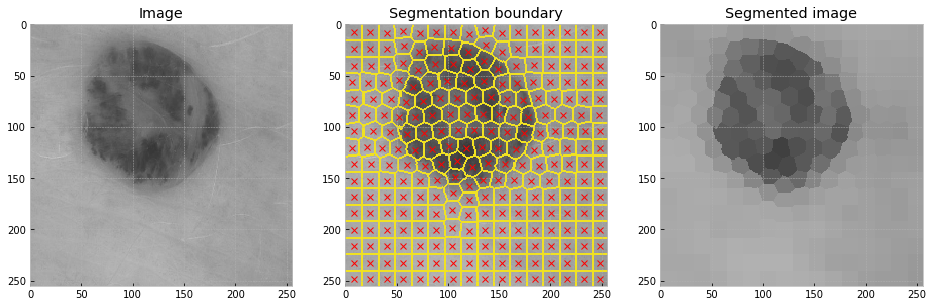

In [7]:
image = nevus_imgs[0] 

# SLIC segmentation
segments = slic(image, 256, compactness=0.3, max_iter=200, multichannel=False, start_label=1)

# Get segmented image
new_image = np.zeros(image.shape)
for i in np.unique(segments):
    cond = segments == i
    new_image[cond] = image[cond].mean()
    
# Compute segmets centroids
regions = regionprops(segments, intensity_image=image)


fig, ax = plt.subplots(1,3, figsize=(16,8))
ax[0].imshow(image, 'gray', vmax=255,vmin=0)
ax[0].set_title('Image')
ax[1].imshow(mark_boundaries(image, segments, color=(240/255,225/255,35/255)), vmax=255,vmin=0)
ax[1].set_title('Segmentation boundary')
ax[2].imshow(new_image, 'gray', vmax=255,vmin=0)
ax[2].set_title('Segmented image')

for props in regions:
    cy, cx = props.centroid
    ax[1].plot(cx, cy, 'rx')
plt.show()

## Segment all images

In [9]:
# Combine some images
all_imgs = np.concatenate((nevus_imgs, melanoma_imgs), axis=0)
all_imgs.shape

(20, 256, 256)

In [10]:
#Compute segmentations  
seg_imgs = []
seg_centers = []

n_segments = 256
compactness = 0.3
max_iter = 200

ii = -1
for img in all_imgs:
    ii+=1
    print(ii,end=' ')
    
    # SLIC segmentation
    segments = slic(img, n_segments, compactness=compactness, max_iter=max_iter, 
                    multichannel=False, start_label=1)
    
    # Compute centers
    regions = regionprops(segments, intensity_image=img)
    seg_centers += [[p.centroid for p in regions]]

    # Get segmented image
    new_image = np.zeros(img.shape)
    for i in np.unique(segments):
        cond = segments == i
        new_image[cond] = img[cond].mean()
    seg_imgs += [new_image]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

NameError: name 'all_imgs' is not defined

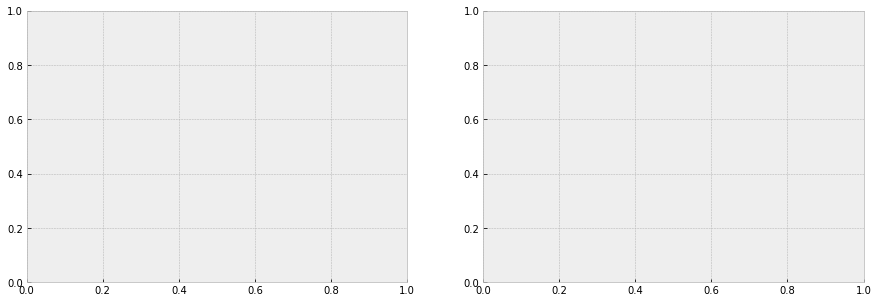

In [8]:
index = 13

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(all_imgs[index], 'gray', vmax=255,vmin=0)
ax[0].set_title('Image')
im = ax[1].imshow(seg_imgs[index], 'gray', vmax=255,vmin=0)
ax[1].set_title('Segmented image. max/min - {:5.1f}/{:5.1f}'.format(
    seg_imgs[index].max(), seg_imgs[index].min()))
plt.colorbar(im)
plt.show()

## Distribution of segmented data

In [48]:
seg_imgs = np.array(seg_imgs)

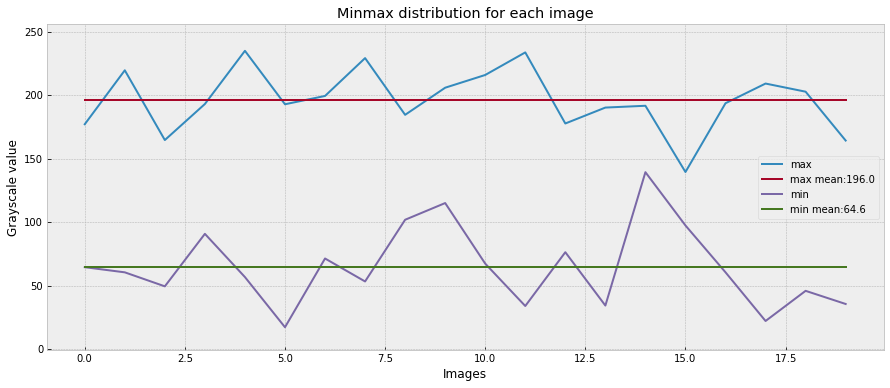

In [49]:

_max = seg_imgs.max(1).max(1)
_min = seg_imgs.min(1).min(1)

m_max = np.zeros(_max.shape) + _max.mean()
m_min = np.zeros(_min.shape) + _min.mean()

plt.figure(figsize=(15,6))
plt.plot(_max, label='max')
plt.plot(m_max, label='max mean:{:3.1f}'.format(_max.mean()))
plt.plot(_min, label='min')
plt.plot(m_min, label='min mean:{:3.1f}'.format(_min.mean()))

plt.ylim(-1,256)
plt.title('Minmax distribution for each image')
plt.legend()
plt.xlabel('Images')
plt.ylabel('Grayscale value')
plt.show()

## Spectral clustering
Data representation: **[ img[x,y], x, y ]**   
where:  
- x, y - coordinats of pixel  
- img[x,y] - color of pixel with coordinats x, y

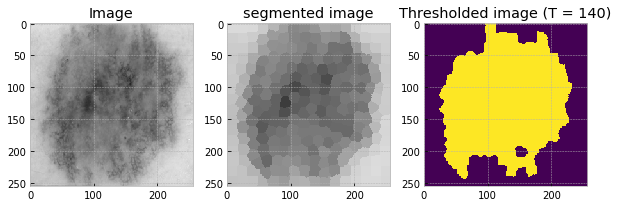

In [58]:
index = 1
img = seg_imgs[index]

fig, ax = plt.subplots(1,3, figsize=(10,3))
ax[0].imshow(all_imgs[index], 'gray', vmax=255,vmin=0)
ax[0].set_title('Image')
ax[1].imshow(img, 'gray', vmax=255,vmin=0)
ax[1].set_title('segmented image')
ax[2].imshow(img < 140)
ax[2].set_title('Thresholded image (T = 140)')
plt.show()

### For all data

In [ ]:
# data = [] 
# for x in range(img.shape[0]):
#     for y in range(img.shape[1]):
#         data += [[img[x,y], x, y]]
# data = np.array(data)
# data.shape

### For center of regions 

In [59]:
data = [] 

for x,y in seg_centers[index]:
    x = int(x)
    y = int(y)
    data += [[img[x,y], x, y]]
    
data = np.array(data)
data.shape

(256, 3)

### Clustering 

In [60]:
import plotly.graph_objects as go

n = go.Scatter3d(x=data[:,0], y=data[:,1], z=data[:,2], 
                 mode='markers',
                 name='nevus',
                 marker=dict(
                     color='rgb(255,169,34)',
                     size=8,
                     opacity=0.8))

# m = go.Scatter3d(x=data[700:,0], y=data[1000:,1], z=data[1000:,2], 
#                  mode='markers',
#                  name='melanomas',
#                  marker=dict(
#                      color='rgb(83,97,255)',
#                      size=3,
#                      opacity=0.8))

fig = go.Figure(data=[n])
fig.update_layout(
    title_text='3D projection',
    height=800,
    width=800
)
fig.show()

In [61]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# X_tsne = TSNE(n_components=2).fit_transform(data[:,:-1])
X_pca = PCA(n_components=2).fit_transform(data[:,:-1])

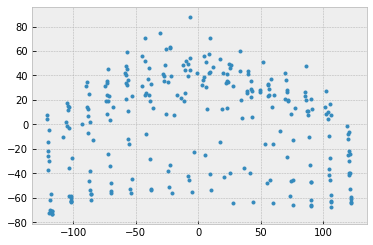

In [62]:
# plt.plot(X_tsne[:,0], X_tsne[:,1], '.')
plt.plot(X_pca[:,0], X_pca[:,1], '.')

[ 0  0  0  0  1  1  1  1  1  1  1  1  0  0  0  0  1  1  1  1  0 -1  1  1
  1  0  0  0  1  0  0 -1  1  1  0  1  1  1  1  1  1  1  0  0  0  0  0  1
  1  1  1  1  1  1  1 -1  1 -1  0  0  1  0  1  1  1  1  1  1 -1  1  1  1
 -1  0  1  1  0  0  1  1  1  1  1  1 -1 -1  1  1  0  1  1  1  0  1  1  1
 -1  1  1  1 -1 -1 -1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1 -1 -1  1
  1  1  1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1  1 -1  1  1  1  1  1
 -1 -1  1 -1  1  1  1  1  1  1 -1 -1  1  1  1  1  1  1 -1  1  1  1 -1  1
  1  1  1 -1  1  1  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1 -1  1
  1  1 -1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]


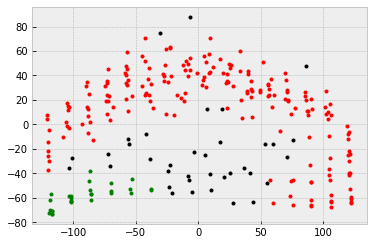

In [63]:
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN

clustering_model = DBSCAN(eps=17, min_samples=6).fit(X_pca)

labels = clustering_model.labels_
print(labels)

if np.unique(labels).size > 1:
#     plt.figure(figsize=(12,6))
    for i in range(0, len(X_pca)):
        if labels[i] == 0:
            plt.plot(X_pca[i,0], X_pca[i,1], '.g')
        elif labels[i] == 1:
            plt.plot(X_pca[i,0], X_pca[i,1], '.r')
        else:
            plt.plot(X_pca[i,0], X_pca[i,1], '.k')

    plt.show()